### このノートブックで追加する項目
* 復元候補をガウスフィルタのみにする。
* データセットにCIFAR10を使う。
* データ拡張を行う。

In [2]:
from skimage.restoration import wiener

### ガウスフィルタを3種類用意する。

In [3]:
import numpy as np
from scipy.stats import multivariate_normal

def get_gauss_filt(sigma):
    f = np.vectorize(lambda x, y: multivariate_normal([0.0, 0.0], sigma).pdf([x, y]))
    X, Y = np.meshgrid(np.arange(-2, 3, 1, dtype=np.float32), np.arange(-2, 3, 1, dtype=np.float32))
    kernel = f(X, Y)
    return kernel / kernel.sum()
    
gauss1 = get_gauss_filt(np.diag([2.0**2]*2))
gauss2 = get_gauss_filt(np.diag([10**2, 10**2]))
gauss3 = get_gauss_filt(np.diag([16**2, 2**2]))

blur_candidate = [gauss1, gauss2, gauss3]

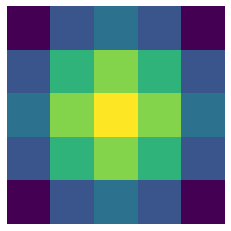

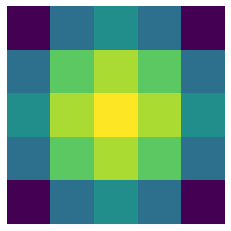

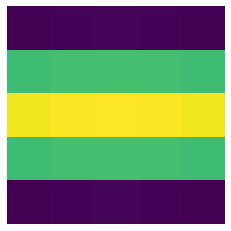

In [4]:
from matplotlib import pyplot as plt

for f in blur_candidate:
    plt.imshow(f)
    plt.axis('off')
    plt.show()

In [6]:
import torch
from torchvision.datasets import CIFAR10, MNIST
from torchvision import transforms
### 逆変換を用意するためにまずそれぞれの画像でのぼやけ方をみる。

mnist = MNIST(root='./data', download=True, train=True, transform=transforms.ToTensor())
cifar10 = CIFAR10(root='./data', download=True, train=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [7]:
def convolve(img, kernel):
    assert len(img.shape) == 3, 'img should have chunnels'
    
    output = np.zeros((img.shape[0], img.shape[1], 3))
    for c in range(img.shape[2]):
        output[:, :, c] = fftconvolve(img[:, :, c], kernel, mode='same')
    return output

In [8]:
from matplotlib import pyplot as plt
from scipy.signal import fftconvolve

def blur(original, kernel):
    if original.shape[2] == 1:
        return fftconvolve(original[:, :, 0], kernel, mode='same')
    return convolve(original, kernel)

def show_filt_blurred(filt, original):
    column_width = len(filt)+1
    plt.figure(figsize=(12, 8))
    plt.subplot(1, column_width, 1)
    plt.title('original')
    plt.axis('off')
    plt.imshow(original)
    
    blurred_imgs = []
    for filt_index, f in enumerate(filt, start=1):
        blurred_img = blur(original, f)
        blurred_imgs.append(blurred_img)
        
        plt.subplot(1, column_width, filt_index+1)
        plt.title('blurred by %d filt' % (filt_index-1))
        plt.axis('off')
        plt.imshow(blurred_img)
    for bimg in blurred_imgs:
        print(np.mean((original.numpy()-bimg)**2))
    return blurred_imgs

0.13918918993349244
0.1351544699662558
0.1379062271299657


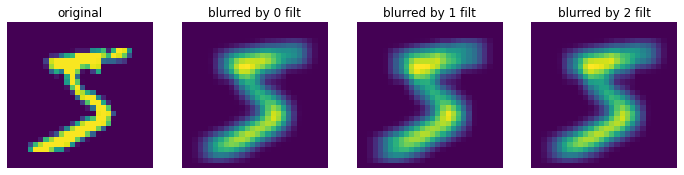

In [21]:
mnist_img, _ = mnist[0]
mnist_img = mnist_img.transpose(0, 1).transpose(1, 2)

result_mnist = show_filt_blurred(blur_candidate, mnist_img)

0.010398051327638894
0.01239755718016873
0.01148498009221213


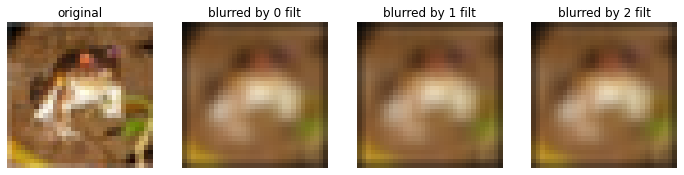

In [9]:
cifar10_img, _ = cifar10[0]
cifar10_img = cifar10_img.transpose(0, 1).transpose(1, 2)

result_cifar10 = show_filt_blurred(blur_candidate, cifar10_img)

In [11]:
def mse(img, restore):
    return np.mean((img-restore)**2)

def label(msg, img, restore):
    return '%s (MSE = %.3lf)' % (msg,mse(img, restore))

original = cifar10_img.numpy()

hyparams = np.random.choice(np.logspace(0, 1, num=10000), 100)

min_val = (0, 100)
for i, f in enumerate(blur_candidate):
    for hp in hyparams:
        blurred_img = result_cifar10[0]
        restore = np.zeros(blurred_img.shape)
        for c in range(3):
            restore[:, :, c] = np.maximum(wiener(blurred_img[:, :, c], f, hp), 0.0)
        val = mse(original, restore)
        if val < min_val[1]:
            min_val = (hp, val)
    print('gauss', i+1)
    print('hyper param', min_val[0])
    print('mse', min_val[1])
    print()

gauss 1
hyper param 1.0148471585006023
mse 0.011164705140073424

gauss 2
hyper param 1.0148471585006023
mse 0.011164705140073424

gauss 3
hyper param 1.0148471585006023
mse 0.011164705140073424



In [12]:
filt_candidate = [
    lambda x: wiener(x, gauss1, 1.09),
    lambda x: wiener(x, gauss2, 1.09),
    lambda x: wiener(x, gauss3, 1.09),
]

ガウス 1


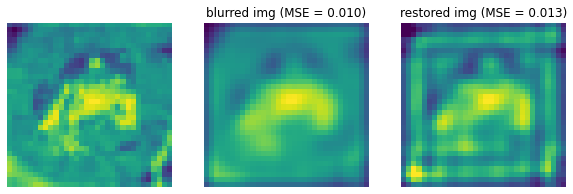

ガウス 2


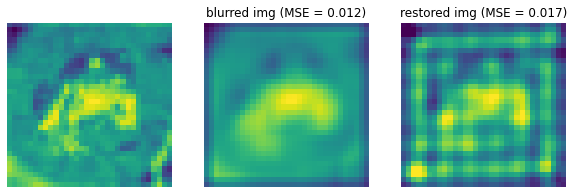

ガウス 3


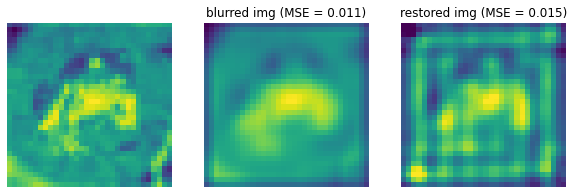

In [19]:
for i, f in enumerate(blur_candidate):
    print('ガウス', i+1)
    blurred_img = result_cifar10[i]
    plt.figure(figsize=(10, 4))
    plt.subplot(131)
    plt.axis('off')
    plt.imshow(original[:, :, 0])
    
    plt.subplot(132)
    plt.title(label('blurred img', original, blurred_img))
    plt.imshow(blurred_img[:, :, 0])
    plt.axis('off')

    restore = np.zeros(blurred_img.shape)
    for c in range(3):
        restore[:, :, c] = np.maximum(wiener(blurred_img[:, :, c], f, 0.01), 0.0)
    plt.subplot(133)
    plt.title(label('restored img', original, restore))
    plt.axis('off')
    plt.imshow(restore[:, :, 0])
    plt.show()